Let's explore our time series!

In [1]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='white')

In [18]:
data = pd.read_csv('data/train.txt', header=None, delim_whitespace=True)
print(data.shape)
data.head()

(45918, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


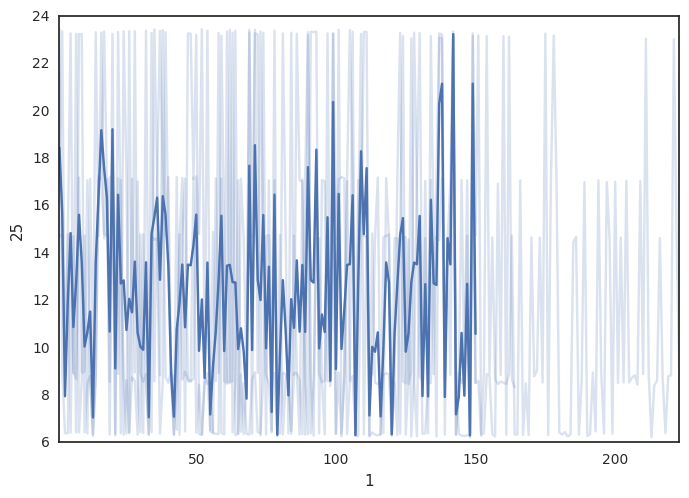

In [35]:
sns.tsplot(data[data[0]<=3], unit=0, time=1, value=25, err_style='unit_traces')

In [7]:
# take only first 2 time series and only first 3 features
data = data[data[0] <= 2][list(range(5))]
data.shape

(387, 5)

In [8]:
grouped = data.groupby(0)
grouped.describe()

1           2           3           4
0                                                      
1 count  223.000000  223.000000  223.000000  223.000000
  mean   112.000000   25.025132    0.591630   51.300448
  std     64.518731   14.197322    0.295972   31.100163
  min      1.000000    0.000100    0.000000    0.000000
  25%     56.500000   10.006250    0.251600   20.000000
  50%    112.000000   25.004200    0.700000   40.000000
  75%    167.500000   35.007700    0.840000   80.000000
  max    223.000000   42.008000    0.842000  100.000000
2 count  164.000000  164.000000  164.000000  164.000000
  mean    82.500000   23.655117    0.565419   49.146341
  std     47.486840   15.120369    0.319083   33.550666
  min      1.000000    0.000300    0.000000    0.000000
  25%     41.750000   10.004700    0.250875   20.000000
  50%     82.500000   25.000650    0.700000   40.000000
  75%    123.250000   41.998125    0.840000   80.000000
  max    164.000000   42.007800    0.842000  100.000000

1         Axes(0.1,0.15;0.363636x0.75)
2    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

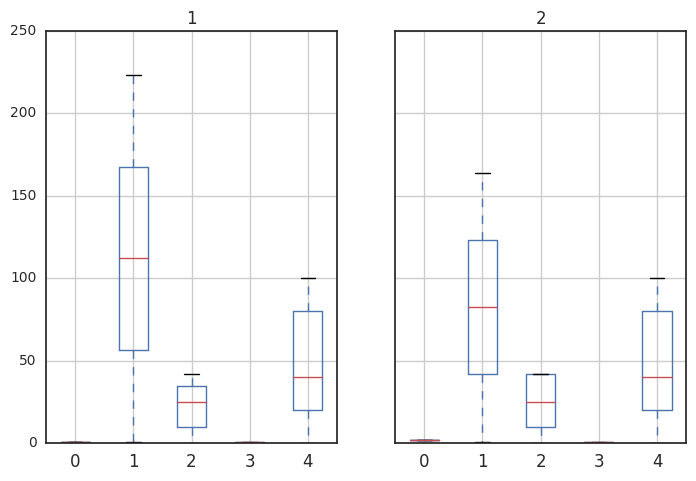

In [9]:
grouped.boxplot()